In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip -d HAM10000


In [5]:
ls HAM10000

ham10000_images_part_1/  HAM10000_images_part_2/  hmnist_28_28_RGB.csv
HAM10000_images_part_1/  HAM10000_metadata.csv    hmnist_8_8_L.csv
ham10000_images_part_2/  hmnist_28_28_L.csv       hmnist_8_8_RGB.csv


Убедились, что всё скачалось.

1) HAM10000_images_part_1/ и HAM10000_images_part_2/ — это изображения кожных заболеваний.

2) HAM10000_metadata.csv — таблица с метаданными (диагноз, пациент и т.д).

3) hmnist_*.csv — версии датасета в формате 8x8 и 28x28 пикселей (они нам не нужны, мы будем работать с оригинальными изображениями)

In [6]:
import os
import pandas as pd

# проверяем количество изображений в папках
part_1 = "HAM10000/ham10000_images_part_1"
part_2 = "HAM10000/ham10000_images_part_2"

print(f"Число изображений в part_1: {len(os.listdir(part_1))}")
print(f"Число изображений в part_2: {len(os.listdir(part_2))}")

# загружаем метаданные
metadata = pd.read_csv("HAM10000/HAM10000_metadata.csv")
metadata.head()

Число изображений в part_1: 5000
Число изображений в part_2: 5015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
print(metadata["dx"].value_counts()) # видим 7 типов кожных поражений, как и написано в описании датасета


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Проверим, что картинки загружены корректно. Выберем случайную:

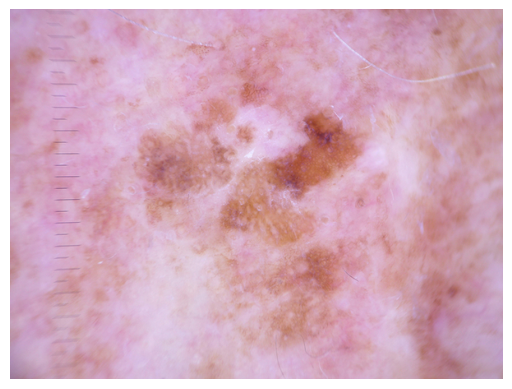

In [8]:
import matplotlib.pyplot as plt
import cv2

img_path = "HAM10000/ham10000_images_part_1/ISIC_0027419.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()


Проверим датасет на пропуски:

In [9]:
print(metadata.isnull().sum())


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


Видим, что есть пропуски в столбце age. Можно заполнить медианным значением по столбцу. А можно медианным значением по каждому диагнозу. Выберем второй вариант:

In [10]:
metadata["age"] = metadata.groupby("dx")["age"].transform(lambda x: x.fillna(x.median()))

metadata.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0


Загрузим маски Насти Агафьиной:

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
path_to_masks = '/content/drive/MyDrive/Third course/DL_work/masks'



Сейчас мы сравним имена изображений в датасете и в папке с масками, чтобы проверить, что маски соответствуют изображениям.

In [14]:
import os


dataset_folder = '/content/HAM10000/'


images_part_1 = os.path.exists(dataset_folder + 'ham10000_images_part_1/')
images_part_2 = os.path.exists(dataset_folder + 'ham10000_images_part_2/')

print("Part 1 exists:", images_part_1)
print("Part 2 exists:", images_part_2)

# получим списки файлов в этих папках
images_part_1_files = os.listdir(dataset_folder + 'ham10000_images_part_1/')
images_part_2_files = os.listdir(dataset_folder + 'ham10000_images_part_2/')

# несколько файлов для проверки
print("Files in part 1:", images_part_1_files[:5])
print("Files in part 2:", images_part_2_files[:5])



Part 1 exists: True
Part 2 exists: True
Files in part 1: ['ISIC_0027319.jpg', 'ISIC_0028203.jpg', 'ISIC_0026581.jpg', 'ISIC_0029041.jpg', 'ISIC_0028429.jpg']
Files in part 2: ['ISIC_0034293.jpg', 'ISIC_0031013.jpg', 'ISIC_0033360.jpg', 'ISIC_0031361.jpg', 'ISIC_0029308.jpg']


для папки HAM10000/ham10000_images_part_1 :

In [15]:
import os

# Путь к папкам с изображениями и масками
images_folder = 'HAM10000/ham10000_images_part_1/'  # или 'HAM10000/ham10000_images_part_2/' в зависимости от части
masks_folder = '/content/drive/MyDrive/Third course/DL_work/masks'  # Путь к папке с масками

# Получаем списки изображений и масок (без расширений)
images_part_1 = [f.split('.')[0] for f in os.listdir(images_folder) if f.endswith('.jpg')]
masks = [f.split('.')[0] for f in os.listdir(masks_folder) if f.endswith('.png')]

# Сравниваем их
matching_images = set(images_part_1).intersection(masks)  # пересечение
missing_images = set(images_part_1) - set(masks)  # изображения, для которых нет масок
extra_masks = set(masks) - set(images_part_1)  # маски, для которых нет изображений

# Выводим результаты
print(f"Совпадающие изображения и маски: {matching_images}")
print(f"Изображения без масок: {missing_images}")
print(f"Маски без изображений: {extra_masks}")


Совпадающие изображения и маски: {'ISIC_0025708', 'ISIC_0025489', 'ISIC_0024560', 'ISIC_0025676', 'ISIC_0025457', 'ISIC_0025387', 'ISIC_0024446', 'ISIC_0025366', 'ISIC_0024823', 'ISIC_0024696', 'ISIC_0024386', 'ISIC_0025507', 'ISIC_0025600', 'ISIC_0024440', 'ISIC_0024442', 'ISIC_0025456', 'ISIC_0024961', 'ISIC_0025218', 'ISIC_0024577', 'ISIC_0024921', 'ISIC_0024424', 'ISIC_0025008', 'ISIC_0024661', 'ISIC_0024631', 'ISIC_0025137', 'ISIC_0024618', 'ISIC_0024856', 'ISIC_0025286', 'ISIC_0024718', 'ISIC_0024786', 'ISIC_0024567', 'ISIC_0025666', 'ISIC_0024427', 'ISIC_0025609', 'ISIC_0025485', 'ISIC_0024651', 'ISIC_0025188', 'ISIC_0025433', 'ISIC_0024472', 'ISIC_0024605', 'ISIC_0025135', 'ISIC_0024860', 'ISIC_0025127', 'ISIC_0024660', 'ISIC_0025123', 'ISIC_0024490', 'ISIC_0025303', 'ISIC_0025246', 'ISIC_0025690', 'ISIC_0025582', 'ISIC_0024815', 'ISIC_0025381', 'ISIC_0025210', 'ISIC_0024501', 'ISIC_0024636', 'ISIC_0025356', 'ISIC_0025035', 'ISIC_0024857', 'ISIC_0024701', 'ISIC_0024453', 'ISIC_

In [16]:
# Подсчитываем количество
print(f"Количество совпадающих изображений и масок: {len(matching_images)}")
print(f"Количество изображений без масок: {len(missing_images)}")
print(f"Количество масок без изображений: {len(extra_masks)}")

Количество совпадающих изображений и масок: 1404
Количество изображений без масок: 3596
Количество масок без изображений: 20


Как видим, 1404 изображений имеют идентичные имена в папке масок. Для дальнейшего обучения будут использованы только 1404 этих изображений.

теперь для папки HAM10000/ham10000_images_part_2 :

In [17]:
# Путь к папкам с изображениями и масками
images_folder2 = 'HAM10000/ham10000_images_part_2/'
masks_folder = '/content/drive/MyDrive/Third course/DL_work/masks'  # Путь к папке с масками

# Получаем списки изображений и масок (без расширений)
images_part_2 = [f.split('.')[0] for f in os.listdir(images_folder2) if f.endswith('.jpg')]
masks2 = [f.split('.')[0] for f in os.listdir(masks_folder) if f.endswith('.png')]

# Сравниваем их
matching_images2 = set(images_part_2).intersection(masks2)  # пересечение
missing_images2 = set(images_part_2) - set(masks2)  # изображения, для которых нет масок
extra_masks2 = set(masks2) - set(images_part_2)  # маски, для которых нет изображений

# Выводим результаты
print(f"Совпадающие изображения и маски: {matching_images2}")
print(f"Изображения без масок: {missing_images2}")
print(f"Маски без изображений: {extra_masks2}")

Совпадающие изображения и маски: set()
Изображения без масок: {'ISIC_0032190', 'ISIC_0032670', 'ISIC_0033086', 'ISIC_0032182', 'ISIC_0033153', 'ISIC_0032998', 'ISIC_0033812', 'ISIC_0033263', 'ISIC_0033755', 'ISIC_0031315', 'ISIC_0031773', 'ISIC_0034169', 'ISIC_0029340', 'ISIC_0034030', 'ISIC_0032278', 'ISIC_0029439', 'ISIC_0034102', 'ISIC_0032696', 'ISIC_0033122', 'ISIC_0029723', 'ISIC_0033287', 'ISIC_0032980', 'ISIC_0033581', 'ISIC_0029394', 'ISIC_0030807', 'ISIC_0033958', 'ISIC_0032087', 'ISIC_0031119', 'ISIC_0032986', 'ISIC_0030407', 'ISIC_0029859', 'ISIC_0029390', 'ISIC_0030938', 'ISIC_0033083', 'ISIC_0031493', 'ISIC_0031661', 'ISIC_0031054', 'ISIC_0032071', 'ISIC_0030524', 'ISIC_0033306', 'ISIC_0029812', 'ISIC_0032374', 'ISIC_0031431', 'ISIC_0032141', 'ISIC_0029827', 'ISIC_0033703', 'ISIC_0034092', 'ISIC_0032568', 'ISIC_0031717', 'ISIC_0033455', 'ISIC_0034263', 'ISIC_0033560', 'ISIC_0032255', 'ISIC_0029386', 'ISIC_0032535', 'ISIC_0033548', 'ISIC_0034111', 'ISIC_0032274', 'ISIC_003

In [18]:
# Подсчитываем количество
print(f"Количество совпадающих изображений и масок: {len(matching_images2)}")
print(f"Количество изображений без масок: {len(missing_images2)}")
print(f"Количество масок без изображений: {len(extra_masks2)}")

Количество совпадающих изображений и масок: 0
Количество изображений без масок: 5015
Количество масок без изображений: 1424


Значит пока будем использовать только part_1

Проверим размерность изображений и масок. Они совпали:

In [19]:
import os
from PIL import Image

# Проверим размер первых 5 изображений и масок
image_paths = [os.path.join(images_folder, f"{name}.jpg") for name in list(matching_images)[:5]]
mask_paths = [os.path.join(masks_folder, f"{name}.png") for name in list(matching_images)[:5]]

for img_path, mask_path in zip(image_paths, mask_paths):
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    print(f"Изображение {os.path.basename(img_path)}: {img.size}, Маска: {mask.size}")


Изображение ISIC_0025708.jpg: (600, 450), Маска: (600, 450)
Изображение ISIC_0025489.jpg: (600, 450), Маска: (600, 450)
Изображение ISIC_0024560.jpg: (600, 450), Маска: (600, 450)
Изображение ISIC_0025676.jpg: (600, 450), Маска: (600, 450)
Изображение ISIC_0025457.jpg: (600, 450), Маска: (600, 450)


Продемонстрируем визуально, что маски и изображения совпадают:

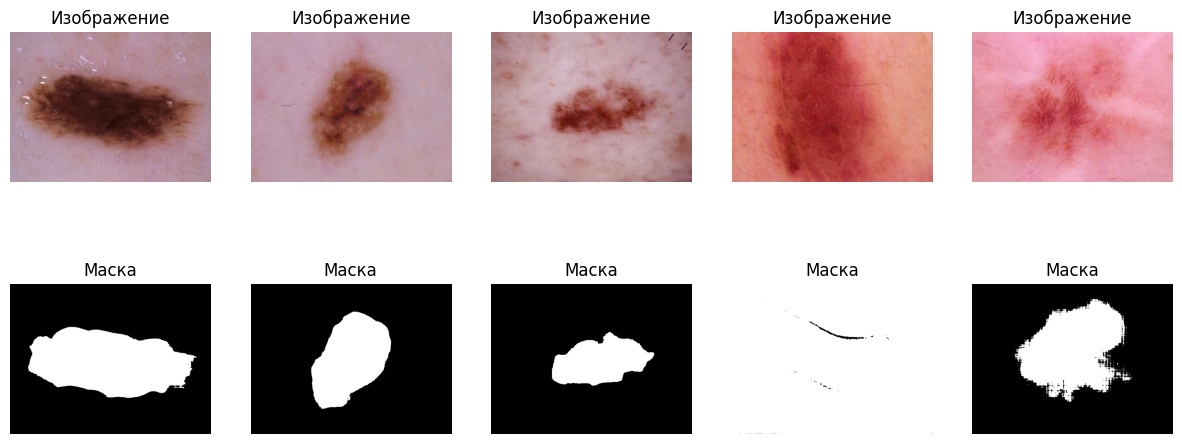

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    img = Image.open(image_paths[i])
    mask = Image.open(mask_paths[i])

    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Изображение")

    axes[1, i].imshow(mask, cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Маска")

plt.show()


С датасетом и масками разобрались. Теперь переходим непосредственно к U-net, будем реализовывать на PyTorch

In [21]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Энкодер
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Боттлнек
        self.bottleneck = DoubleConv(512, 1024)

        # Декодер
        self.upconv4 = UpConv(1024, 512)
        self.dec4 = DoubleConv(1024, 512)

        self.upconv3 = UpConv(512, 256)
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = UpConv(256, 128)
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = UpConv(128, 64)
        self.dec1 = DoubleConv(128, 64)

        # Выходной слой
        self.conv_out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Энкодер
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Боттлнек
        bottleneck = self.bottleneck(self.pool(enc4))

        # Декодер
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv_out(dec1))

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                             kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.up(x)

Загрузим туда датасет, где есть картинки и маски. Это 1404 штуки. Ранее уже считали это, ещё раз продублируем, просто для удобства(чтобы не листать и сразу всё перед глазами)

In [22]:
import os

# пути к папкам
images_folder = 'HAM10000/ham10000_images_part_1/'
masks_folder = '/content/drive/MyDrive/Third course/DL_work/masks'

# списки файлов без расширений
images = {f.split('.')[0] for f in os.listdir(images_folder) if f.endswith('.jpg')}
masks = {f.split('.')[0] for f in os.listdir(masks_folder) if f.endswith('.png')}

# берём только те, у кого есть и картинка, и маска
valid_files = images.intersection(masks)

print(f"Число изображений и масок, которые можно использовать: {len(valid_files)}")  #1404


Число изображений и масок, которые можно использовать: 1404


Теперь делаем PyTorch Dataset только для этих файлов:

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

class SkinDataset(Dataset):
    def __init__(self, image_dir, mask_dir, valid_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.valid_files = list(valid_files)  # переводим в список
        self.transform = transform

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        img_name = self.valid_files[idx]
        img_path = os.path.join(self.image_dir, img_name + ".jpg")
        mask_path = os.path.join(self.mask_dir, img_name + ".png")

        image = cv2.imread(img_path)
        if image is None:
            print(f"Ошибка: не удалось загрузить {img_path}")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128)) / 255.0  # нормализация

        # загружаем маску
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Ошибка: не удалось загрузить {mask_path}")
            return None
        mask = cv2.resize(mask, (128, 128)) / 255.0  # теперь маска тоже нормализована

        # переводим в тензоры
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # добавляем канал

        return image, mask

#создаём датасет
dataset = SkinDataset(images_folder, masks_folder, valid_files)

#создаём DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

#чекаем загрузку
images, masks = next(iter(dataloader))
print(f"Загружено {images.shape[0]} изображений размером {images.shape[1:]}, который DataLoader загружает за один раз")  # (8, 3, 128, 128)


Загружено 8 изображений размером torch.Size([3, 128, 128]), который DataLoader загружает за один раз


In [25]:
len(dataloader.dataset)  # 1404


1404

Теперь разделим датасет на обучающую, валидационную и тестовую выборки:

In [26]:
from torch.utils.data import random_split

# 80% train, 10% val, 10% test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Остаток

# разделяем
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# чекаем размеры
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 1123, Val: 140, Test: 141


Теперь надо сделать DataLoader для каждой выборки, чтобы модель могла загружать данные батчами:

In [27]:
from torch.utils.data import DataLoader

# парамтры загрузки
batch_size = 8  # тут хз, можно увеличить, если позволяет память
num_workers = 2 # использую gpu collab, в интернете прочитала, что нужно поставить > 1 в таком случае

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# проверяем размер батчей
images, masks = next(iter(train_loader))
print(f"Train batch size: {images.shape}")  #[8, 3, 128, 128]


Train batch size: torch.Size([8, 3, 128, 128])


В качестве оптимизатора будем использовать Adam, а для функции потерь: binary cross-entropy

In [28]:
import torch.optim as optim
device = torch.device("cuda:0")
model = UNet().to(device)  # Переносим модель на GPU

optimizer = optim.Adam(model.parameters(), lr=0.001)

# ф-я потерь
criterion = nn.BCEWithLogitsLoss()


In [29]:
import torch
torch.cuda.is_available()


True

Сделаем распределение весов в loss-функции

In [ ]:
class WeightedBCELoss(nn.Module):
    def __init__(self, weight_positive):
        super().__init__()
        self.weight = weight_positive

    def forward(self, input, target):
        loss = - (self.weight * target * torch.log(input) +
                (1 - target) * torch.log(1 - input))
        return torch.mean(loss)

# Инициализация с коэффициентом для положительных классов
criterion = WeightedBCELoss(weight_positive=2.0)

In [ ]:
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
import torch
import numpy as np

def calculate_iou(pred_mask, true_mask):
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def calculate_dice(pred_mask, true_mask):
    intersection = (pred_mask * true_mask).sum()
    return (2. * intersection + 1e-6) / (pred_mask.sum() + true_mask.sum() + 1e-6)

def calculate_metrics(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()

    iou = calculate_iou(preds, targets)
    dice = calculate_dice(preds, targets)

    tp = (preds * targets).sum()
    fp = (preds * (1 - targets)).sum()
    fn = ((1 - preds) * targets).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return {
        'iou': iou.item(),
        'dice': dice.item(),
        'precision': precision.item(),
        'recall': recall.item()
    }

In [ ]:
import matplotlib.pyplot as plt

def plot_results(image, true_mask, pred_mask, threshold=0.5):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.cpu().numpy().squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow((pred_mask > threshold).float().cpu().numpy().squeeze(), cmap='gray')
    plt.title('Prediction')

    plt.show()

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    metrics = {'iou': [], 'dice': [], 'precision': [], 'recall': []}

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            batch_metrics = calculate_metrics(outputs, masks)

            for key in metrics:
                metrics[key].append(batch_metrics[key])

    # Усреднение метрик по всему датасету
    return {key: np.mean(values) for key, values in metrics.items()}

Epoch 1/5, Train Loss: 0.4496
Epoch 2/5, Train Loss: 0.3762
Epoch 3/5, Train Loss: 0.3390
Epoch 4/5, Train Loss: 0.3083
Epoch 5/5, Train Loss: 0.2979

Validation Metrics:
IoU: 0.6733
Dice: 0.7979
Precision: 0.8637
Recall: 0.7672


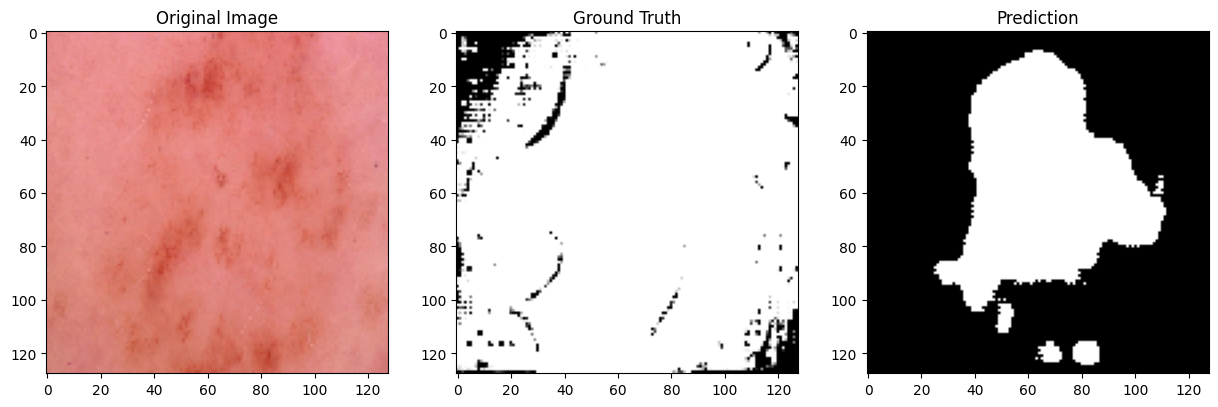

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# Добавим цикл обучения
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

# Цикл обучения и валидации
num_epochs = 5  # Для примера, обычно нужно 50-100. Одна ерунда, всё равно не работает

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

# Оценка модели
test_metrics = evaluate_model(model, val_loader, device)
print("\nValidation Metrics:")
print(f"IoU: {test_metrics['iou']:.4f}")
print(f"Dice: {test_metrics['dice']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")

# Визуализация
image, mask = val_dataset[0]
pred = model(image.unsqueeze(0).to(device))
plot_results(image, mask, pred.squeeze(0).detach().cpu())

In [ ]:
torch.save(model.state_dict(), "5_epoch_model.ckpt")